# Regression

_Author: Christoph Rahmede_

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.simplefilter('ignore')

## Load the data

In [2]:
df = pd.read_csv('../../../dataset-collection/auto-mpg/auto-mpg.csv',
                 sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(3), object(2)
memory usage: 33.7+ KB


## Regression in a nutshell

Linear regression with one predictor:

$$
y = \beta_0+\beta_1 x+ \epsilon
$$

Minimize residual sum of squares:

$$
L = \sum_{i=1}^n (y_i-\hat{y}_i)^2
$$

where $\hat{y}_i=\beta_0+\beta_1 X_i$.


This gives

$$
\begin{eqnarray*}
\beta_0 &=& \bar{y}-\beta_1\bar{x}\\
\beta_1 &=& r_{xy}\frac{s_y}{s_x}
\end{eqnarray*}
$$

with the bars denoting the respective means and $r_{xy}$ the correlation between outcome and predictor variable.

The same result can be obtained through maximum likelihood estimation from the likelihood function

$$
{\rm likelihood} = \Pi_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(y_i-\hat{y}_i)^2}{2\sigma^2}}
$$

where $\sigma$ is the standard deviation of the residuals and normally distributed residuals are assumed.


Regression on more than one predictor follows the same principles. The model parametrization is

$$
y = \beta_0+\beta_1 x+ \beta_2 x_2+\ldots+\beta_p x_p+\epsilon
$$

which can be written in the compact form 

$$
y = X\beta+\epsilon
$$

with the data matrix $X$ containing all the predictions and a column with ones for the intercept.

In that case the beta coefficients are obtained by

$$
\beta = (X^T X)^{-1}X^T y
$$

## Simple linear regression

Let's start by using just one single predictor, for example horsepower, which should serve to predict mpg.

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
X = df[['horsepower']]
y = df.mpg

### Regression using seaborn

That task can actually be performed by seaborn, as we have seen before.

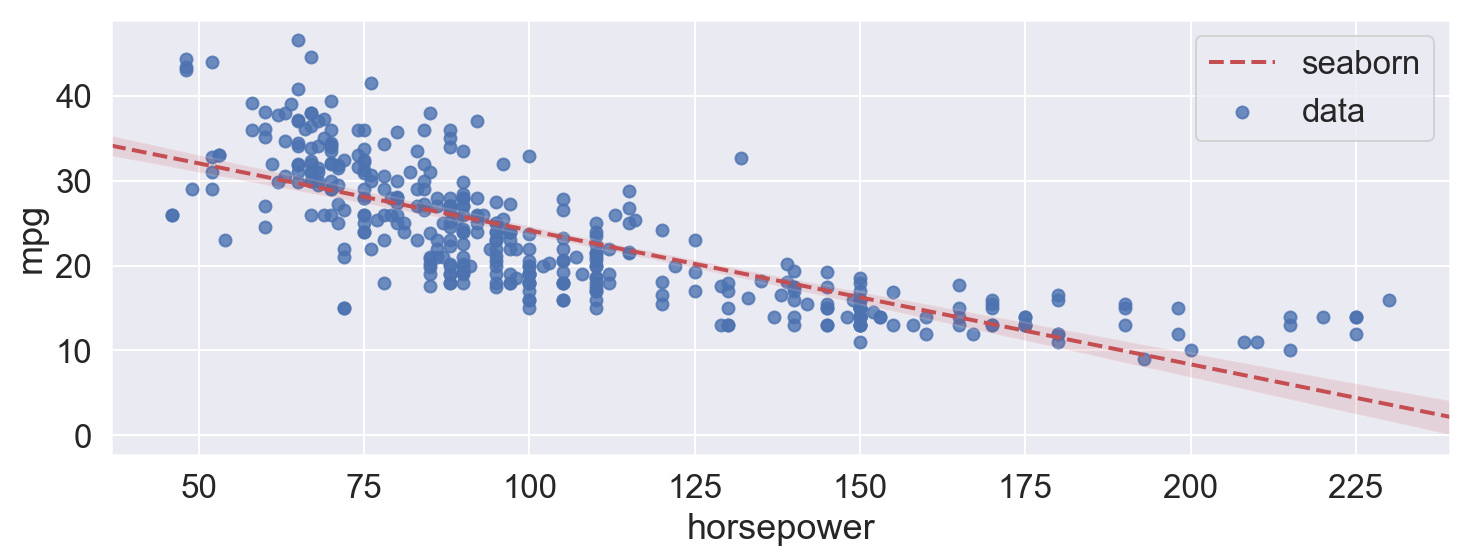

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.regplot(x='horsepower', y='mpg', data=df,
            line_kws={'linewidth': 2, 'ls': '--',
                      'color': 'r', 'label': 'seaborn'},
            ax=ax, label='data')
ax.legend()
plt.show()

### Comparing to the baseline

If we did not have any predictor, our best guess for the target would be simply the mean. Any model predictions will be assessed against this baseline prediction.

In [6]:
print('Baseline:', y.mean())

Baseline: 23.44591836734694


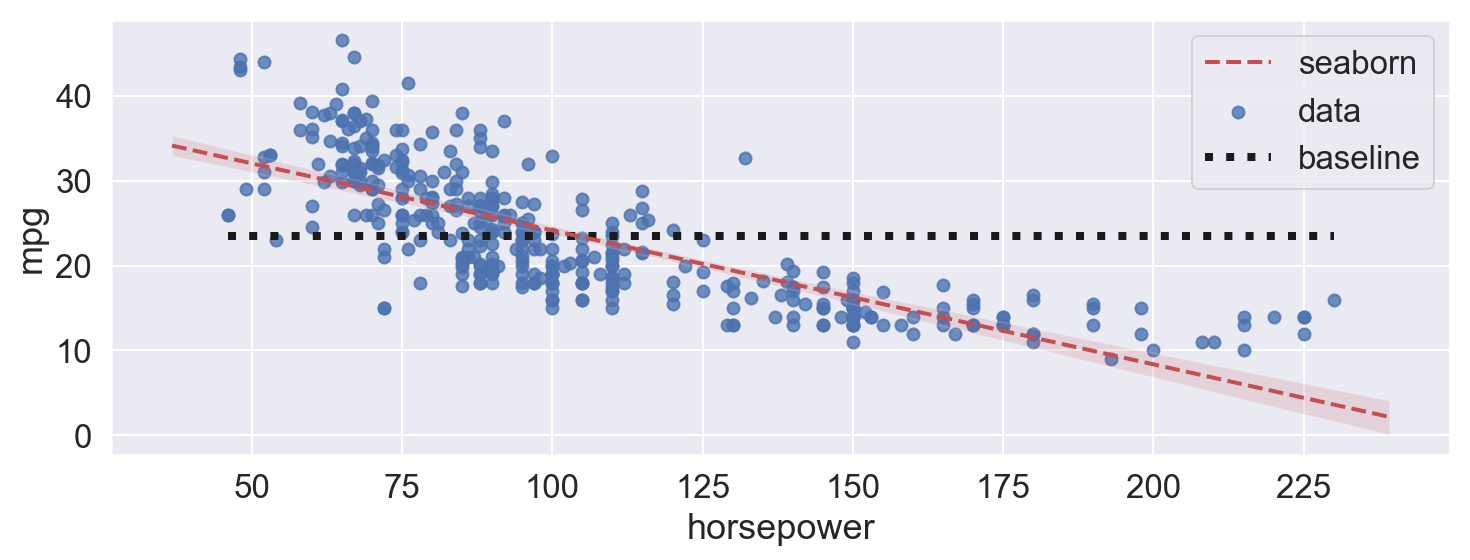

In [7]:
ax.hlines(y.mean(), df.horsepower.min(), df.horsepower.max(),
          lw=4, linestyle=':', color='k', label='baseline')
ax.legend()
fig

### Scikit-learn model fit

Now we use scikit-learn to fit a linear regression with horsepower as the predictor.

In [8]:
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
residuals = y-predictions
model.score(X, y)

0.6059482578894348

Scikit-learn directly returns the R2 score. Equivalently we can look at the mean squared error or root mean squared error. 

$$
\begin{eqnarray*}
{\rm MSE} &=& \frac{1}{n}\sum_{i=1}^n (y_i-\hat{y}_i)^2\\
{\rm Var(y)} &=& \frac{1}{n}\sum_{i=1}^n (y_i-\bar{y})^2\\
R^2 &=& 1-\frac{\rm MSE}{\rm Var(y)}
\end{eqnarray*}
$$

In [9]:
from sklearn.metrics import r2_score, mean_squared_error

In [10]:
print('R2:\t', r2_score(y, predictions))
print('MSE:\t', mean_squared_error(y, predictions))
print('RMSE:\t', mean_squared_error(y, predictions)**0.5)

R2:	 0.6059482578894348
MSE:	 23.943662938603108
RMSE:	 4.893226230065713


In [11]:
# that is how the R2 scores is calculated
1 - mean_squared_error(y, predictions) / y.var(ddof=0)

0.6059482578894348

### Plotting the regression line

With the model coefficients we can make predictions and obtain the regression line. It matches the seaborn result.

In [12]:
print(model.coef_)
print(model.intercept_)

[-0.15784473]
39.93586102117047


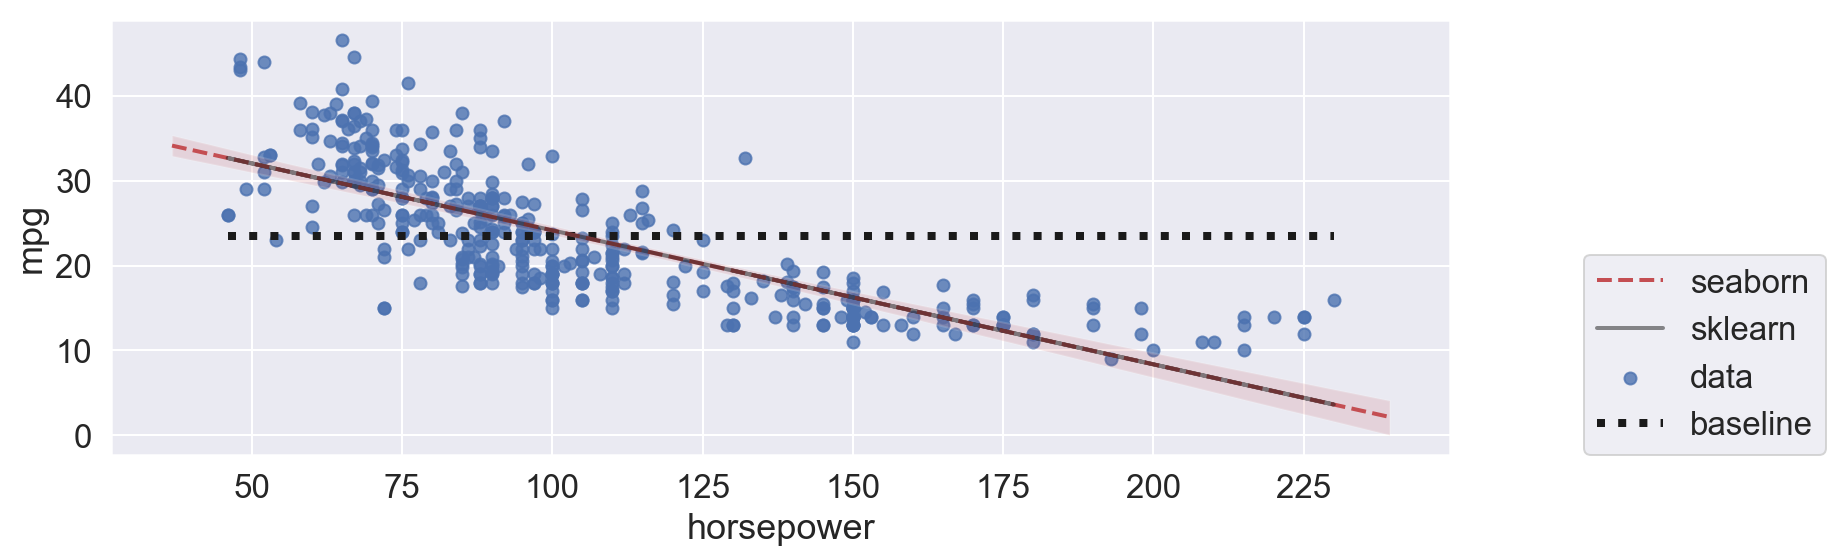

In [13]:
ax.plot(X, model.intercept_+model.coef_*X, lw=2,
        color='k', alpha=0.5, label='sklearn')
ax.legend(loc=[1.1, 0])
fig

### Illustrating the residuals

The residuals are the differences between the true and predicted values, i.e. the vertical distance of each observation from the regression line. We can illustrate them in the following way:

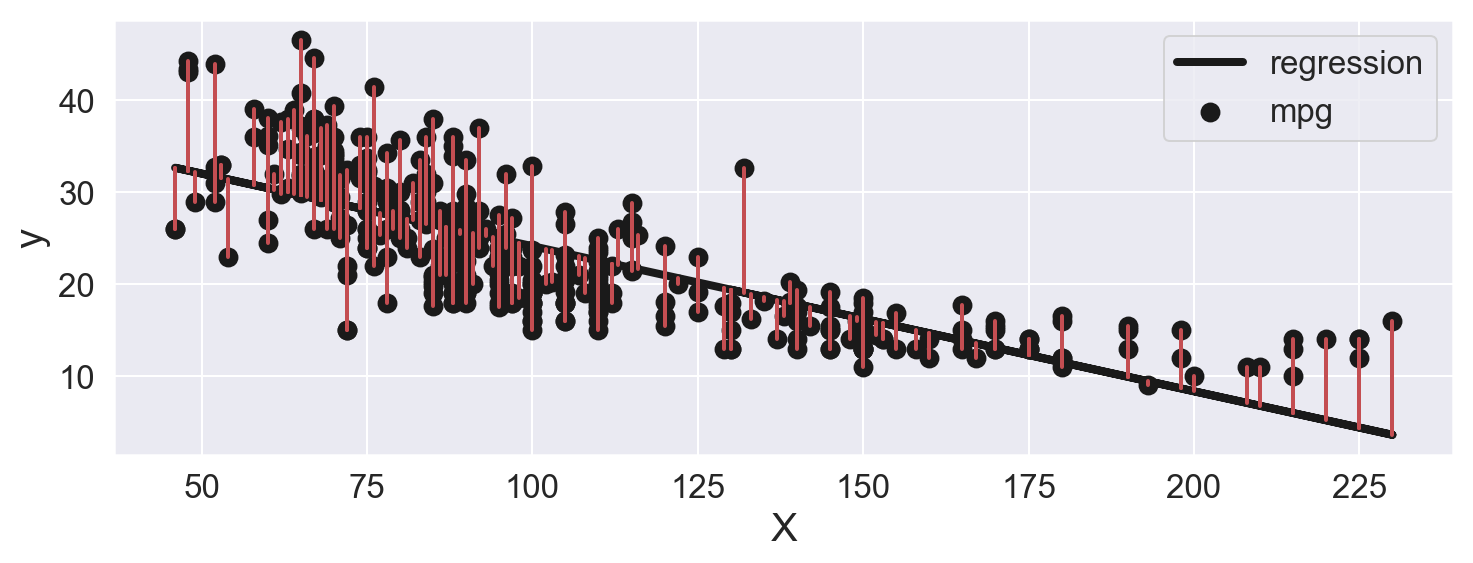

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(X, y, c='k', s=80)
ax.plot(X, predictions, color='k', lw=4, label='regression')
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('y', fontsize=20)
for index, pred in enumerate(predictions):
    ax.plot([X.iloc[index, 0]]*2,
            (y.iloc[index], pred), 'r-', lw=2)
ax.legend()
plt.show()

### Predicted versus true values

We can compare the true and predicted values versus each other. Accurate predictions would be on top of the red line.

In [15]:
model.score(X, y)

0.6059482578894348

[0.60594826] 9.238904978035158


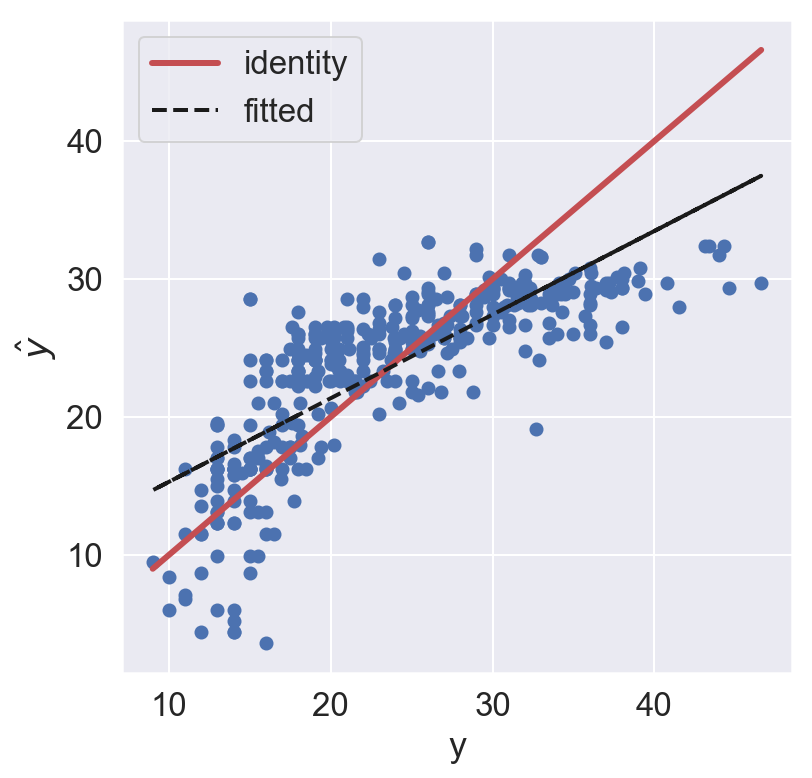

In [16]:
model_y = LinearRegression()
model_y.fit(y.values.reshape(-1, 1), predictions)
print(model_y.coef_, model_y.intercept_)

plt.figure(figsize=(6, 6))
plt.scatter(y, predictions)
plt.plot([y.min(), y.max()], [y.min(),y.max()], 
         lw=3, color='r', label='identity')
plt.plot(y, model_y.predict(y.values.reshape(-1, 1)),
         lw=2, linestyle='--', color='k', label='fitted')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')
plt.legend()
plt.show()

### Residuals versus predictor variable

It can also be informative to plot the residuals versus the predictors or the predicted values. The former is implemented in seaborn. Note that seaborn allows to add a lowess curve (locally weighted scatterplot smoothing) as  a smooth approximation. We can add it ourselves using statsmodels.

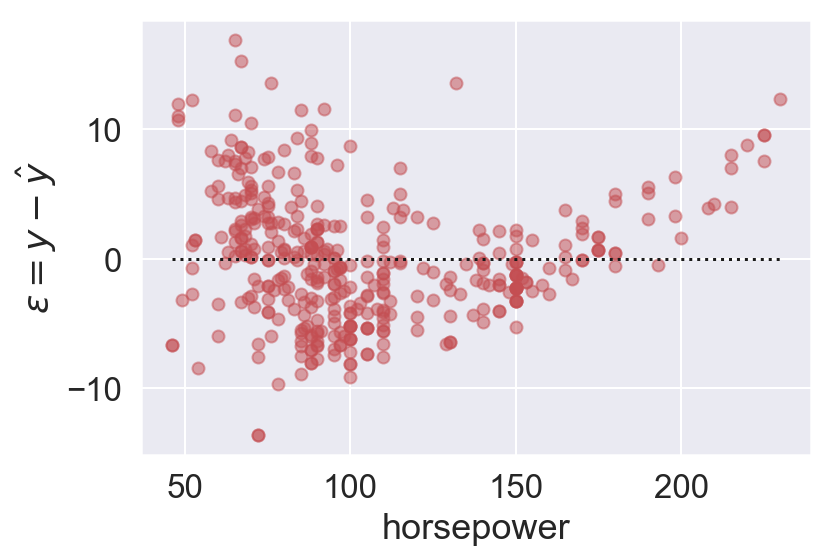

In [17]:
plt.scatter(X, residuals, color='r', alpha=0.5)
plt.hlines(0, X.min(), X.max(), linestyle=':')
plt.xlabel('horsepower')
plt.ylabel('$\epsilon=y-\hat{y}$')
plt.show()

In [18]:
import statsmodels.api as sm
lowess_fit = sm.nonparametric.lowess(residuals, df.horsepower)

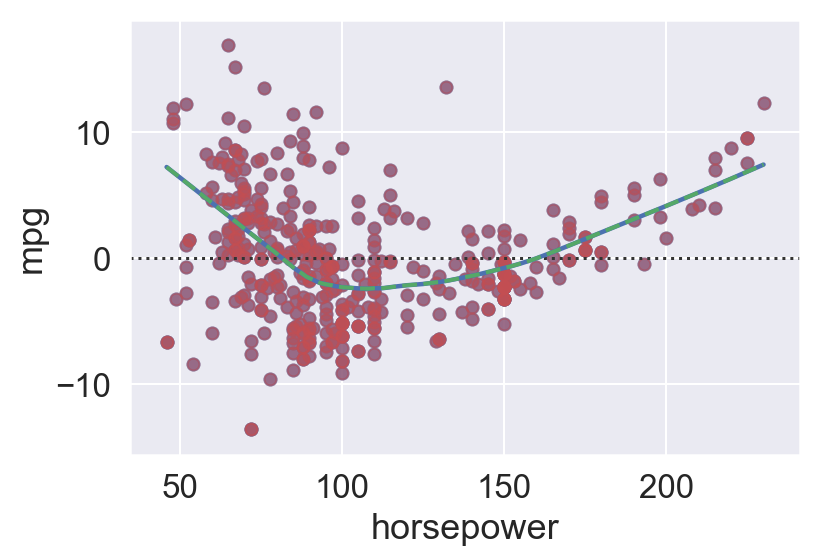

In [19]:
sns.residplot(x='horsepower', y='mpg', data=df, lowess=True)
plt.scatter(df.horsepower, residuals, color='r', alpha=0.5)
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='g', lw=2, ls='--', label='lowess')
plt.show()
plt.show()

### Residuals versus predicted values

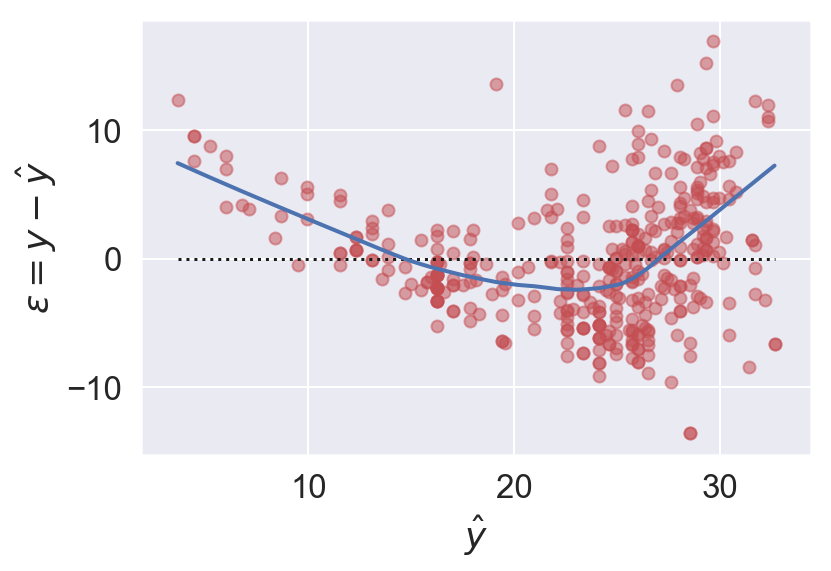

In [20]:
lowess_fit = sm.nonparametric.lowess(residuals, predictions)
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='b', lw=2, label='lowess')
plt.scatter(predictions, residuals, color='r', alpha=0.5)
plt.hlines(0, predictions.min(), predictions.max(), linestyle=':')
plt.xlabel('$\hat{y}$')
plt.ylabel('$\epsilon=y-\hat{y}$')
plt.show()

### Distribution of residuals
In ordinary least squares regression we would expect the residuals to be normally distributed. We can check this assumption by plotting the distribution of the residuals normalized with respect to their standard deviation and comparing against the standard normal distribution (mean equal 0 and standar deviation equal 1).

In [21]:
from scipy.stats import norm

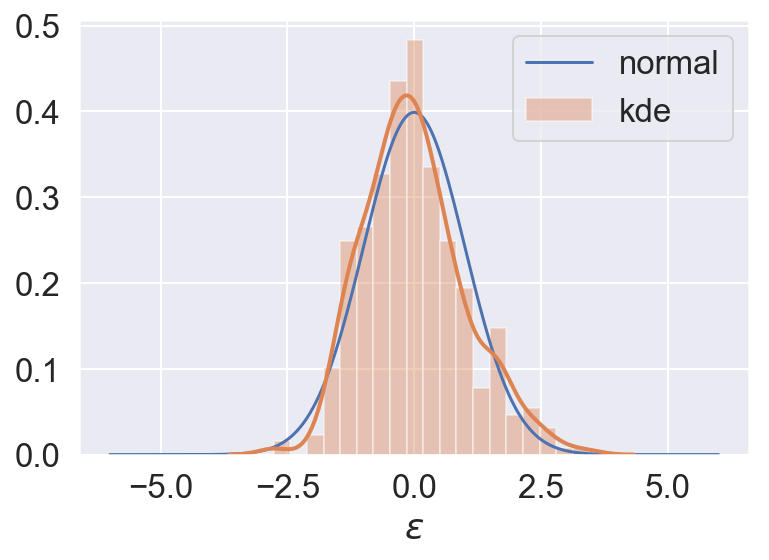

In [22]:
x_vals = np.linspace(-6,6,1000)
plt.plot(x_vals, norm().pdf(x_vals), label='normal')

sns.distplot(residuals/residuals.std(), kde_kws={'linewidth': 2}, label='kde')
plt.xlabel('$\epsilon$')
plt.legend()
plt.show()

## Nonlinear dependence

We can take nonlinear dependencies on features into account for example by creating polynomials out of them. 

In [23]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [24]:
poly = PolynomialFeatures(degree=2)

In [25]:
X = poly.fit_transform(df[['horsepower']])
#X = np.log(df[['horsepower']])

In [26]:
X = pd.get_dummies(df.select_dtypes(include=['float', 'int']).drop(
    ['mpg'], axis=1), columns=['origin'], drop_first=True)

In [27]:
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
print(model.score(X, y))
print(model.coef_, model.intercept_)

predictions = model.predict(X)
residuals = y-predictions

0.8241994699119171
[-0.48970942  0.02397864 -0.01818346 -0.00671038  0.07910304  0.77702694
  2.63000236  2.85322823] -17.954602067290043


In [28]:
df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name', 'brand'],
      dtype='object')

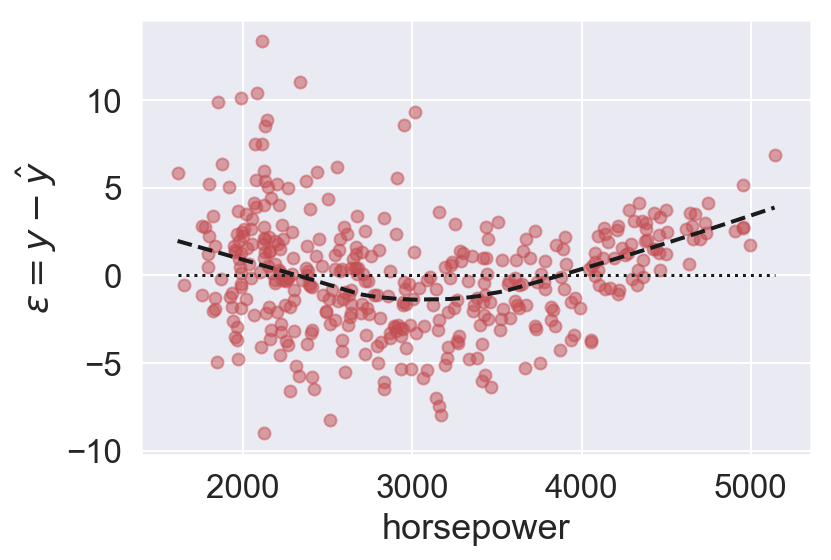

In [29]:
i = 3
lowess_fit = sm.nonparametric.lowess(residuals, X.values[:,i])
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='k', ls='--', lw=2, label='lowess')
plt.scatter(X.values[:, i], residuals, color='r', alpha=0.5)
plt.hlines(0, X.values[:, i].min(), X.values[:, i].max(), linestyle=':')
plt.xlabel('horsepower')
plt.ylabel('$\epsilon=y-\hat{y}$')
ax.legend()
plt.show()

In [30]:
from scipy.stats import norm

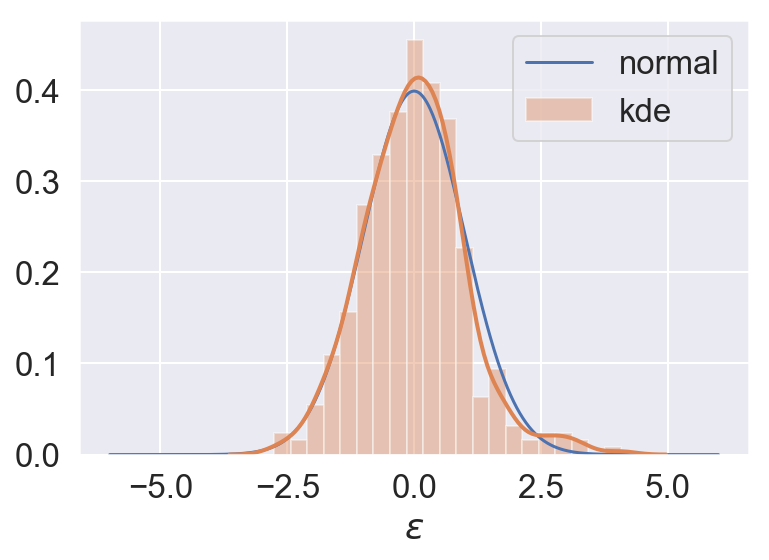

In [31]:
x_vals = np.linspace(-6,6,1000)
plt.plot(x_vals, norm().pdf(x_vals), label='normal')

sns.distplot(residuals/residuals.std(), kde_kws={'linewidth': 2}, label='kde')
plt.xlabel('$\epsilon$')
plt.legend()
plt.show()

## Multiple predictors and model tuning

With multiple predictors we can create a large variety of models including any combinations of those predictors with more or less complicated dependencies. More predictors means having more model coefficients and more flexible models. We don't want to become too flexible since otherwise we face the problem of overfitting, fitting the training data very well without being able to make good predictions for unseen data.

Therefore we have to carefully select the features to be used and find ways to test our model efficiently. With many features a careful selection might be unfeasible. A better way is to keep the model flexibility under control even though including a lot of features. This can be achieved by using regularized regression models like Lasso, Ridge or Elastic Net. 

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

To take categorical variables with $k$ category levels into account, we have to transform them to $k$ binary variables by dummifying them. Each variable expresses presence or absence of the attribute. Since one of the variables is redundant, we retain only $k-1$ of them.

In pandas, we can dummify using `pd.get_dummies()`. This command will recognize categorical variables unless they are encoded numerically. Then we have to indicated the columns which should be dummified explicitly. To drop the first of the resulting variables, set `drop_first=True`.

In [33]:
X = df.copy()
y = X.pop('mpg')
X.drop(['brand', 'name'], axis=1, inplace=True)
X = pd.get_dummies(X, columns=['origin'], drop_first=True)
X.head()

,cylinders,displacement,horsepower,weight,acceleration,year,origin_2,origin_3
0,8,307.0,130.0,3504.0,12.0,70,0,0
1,8,350.0,165.0,3693.0,11.5,70,0,0
2,8,318.0,150.0,3436.0,11.0,70,0,0
3,8,304.0,150.0,3433.0,12.0,70,0,0
4,8,302.0,140.0,3449.0,10.5,70,0,0


If we have more than one possibility of building a model (that is always) we would like to understand which is the best model (predictive, interpretable, ....). In particular the best model should make sense when applied to the "real" world. Our goal is therefore to produce a ranking of all possible models. Creating train-test splits and using cross-validation for model selection serve for preparing us for reality.

We split our data into a train and a test set. It is crucial that the test set is set aside and never looked at during model fitting, since it should serve for simulating having new data  on which the predictions should lead to reasonable results. The remaining training data is used for fitting the model. Before going to the "real world" (i.e. the test data) we have to be reasonably sure that our model generalizes well enough. Therefore we use cross validation on the training data to produce the model ranking. 

In k-fold cross validation, we split the data into a fixed number of buckets. Then we produce as many fits as we have buckets, using each time all but one of the buckets for model fitting, and evaluate on the remaining bucket. Finally we average the scores obtained from each cross validation step. The model ranking is produced solely from the averaged cross-validation scores for each model. 

Once the best model is determined, we fit this model on the whole training set and make predictions on the test set. The ranking for different model candidates might be different on the test set than during cross validation, but that we could not have known and are therefore not allowed to adjust the model ranks.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

Whereas ordinary least squares regression will lead to the same predictions with or without standard scaling, as soon as we add regularization it is mandatory.

In [35]:
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [36]:
# create a linear regression model instance
model = LassoCV(  # alphas=np.logspace(-5,1,300),
    cv=5)

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

baseline_train = mean_squared_error(y_train, [y_train.mean()]*len(X_train))
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

Cross-validated training scores: [0.82169597 0.72461624 0.81273522 0.79753775 0.83027649]
Mean cross-validated training score: 0.7973723331612114
Training Score: 0.820885563147985
Test Score: 0.8282515210520177


We would like to assess the importance of the different features for our model predictions. In linear regression we can do so by comparing the magnitude of the model coefficients. This makes only sense if the features have been standardized.

In [37]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

,coefficients,coef_abs
cylinders,-0.139024,0.139024
displacement,1.952747,1.952747
horsepower,-0.212855,0.212855
weight,-6.151142,6.151142
acceleration,0.503567,0.503567
year,2.800312,2.800312
origin_2,0.949717,0.949717
origin_3,1.064103,1.064103


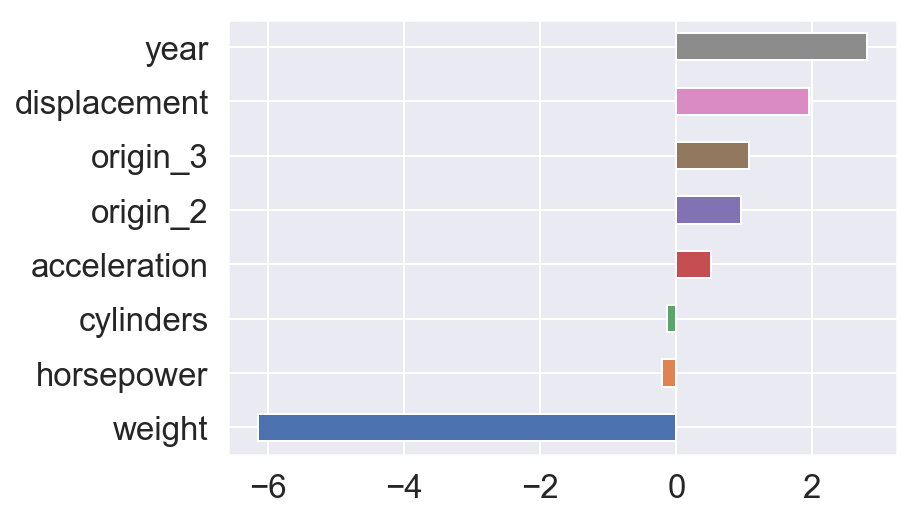

In [38]:
# plot the magnitude of the coefficients
df_coef['coefficients'].sort_values().plot(kind='barh')
plt.show()

We can obtain the best regularization parameter through `LassoCV`, or, if we want also additional hyperparameters, through grid search. The scikit-learn methods find the best configuration automatically, but it can be informative to illustrate how the scores change with the hyperparameters. This will inform us about how to further narrow down our search.

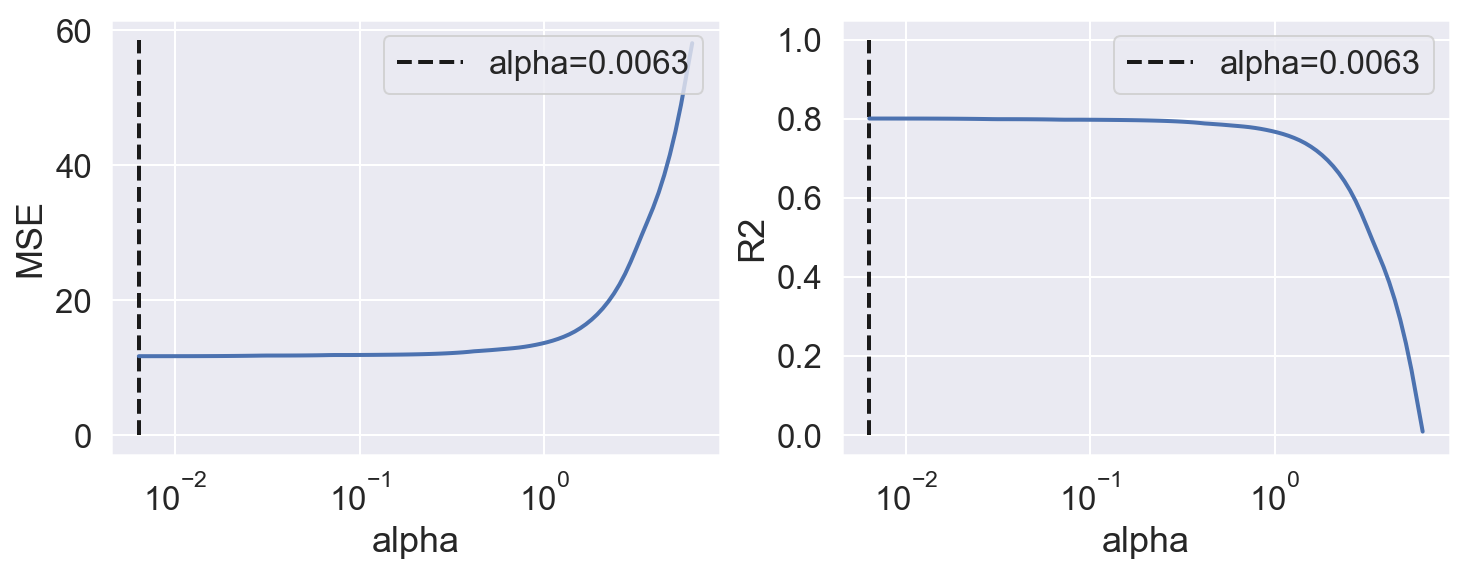

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot(model.alphas_, np.mean(model.mse_path_, axis=1), lw=2)
ax[0].vlines(model.alpha_, 0, baseline_train, lw=2, linestyle='--',
             label='alpha={:.2}'.format(model.alpha_))
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('MSE')
ax[0].set_xscale('log')
ax[0].legend(loc='upper right')

ax[1].plot(model.alphas_, 
           1-np.mean(model.mse_path_, axis=1)/baseline_train, 
           lw=2)
ax[1].vlines(model.alpha_, 0, 1, lw=2, linestyle='--',
             label='alpha={:.2}'.format(model.alpha_))
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('R2')
ax[1].set_xscale('log')
ax[1].legend(loc='upper right')
plt.show()

## Learning curve

We perform cross validation to obtain a better estimate of the generalization error of our model. Ideally we would like to have that cross validated training scores and test scores are at the same level. With enough training data we should be well prepared for facing any new situations. Since model fitting might be computationally costly, we would also like to know how much training data we actually need. That can be illustrated through a learning curve. A nice implementation is given by scikit-plot.

For the learning curve, subsamples are created from the dataset (default or user-defined choice). Then the model is fitted on these subsamples through cross validation giving each time a score on the current training set and a score on the current test set. 

In [40]:
import scikitplot as skplt

In [41]:
training_sizes, train_scores, test_scores = skplt.estimators.learning_curve(
    model, X_train, y_train, cv=5, scoring='r2')

In [42]:
training_sizes

array([ 25,  81, 137, 193, 250])

In [43]:
train_scores

array([[0.90098617, 0.84840247, 0.84840247, 0.84840247, 0.84840247],
       [0.82516465, 0.83509522, 0.82452039, 0.82452039, 0.82452039],
       [0.8198757 , 0.8353515 , 0.81862905, 0.82130897, 0.82130897],
       [0.8035369 , 0.8277463 , 0.80173576, 0.82322016, 0.82018027],
       [0.81973717, 0.83225618, 0.81904232, 0.82448702, 0.81680966]])

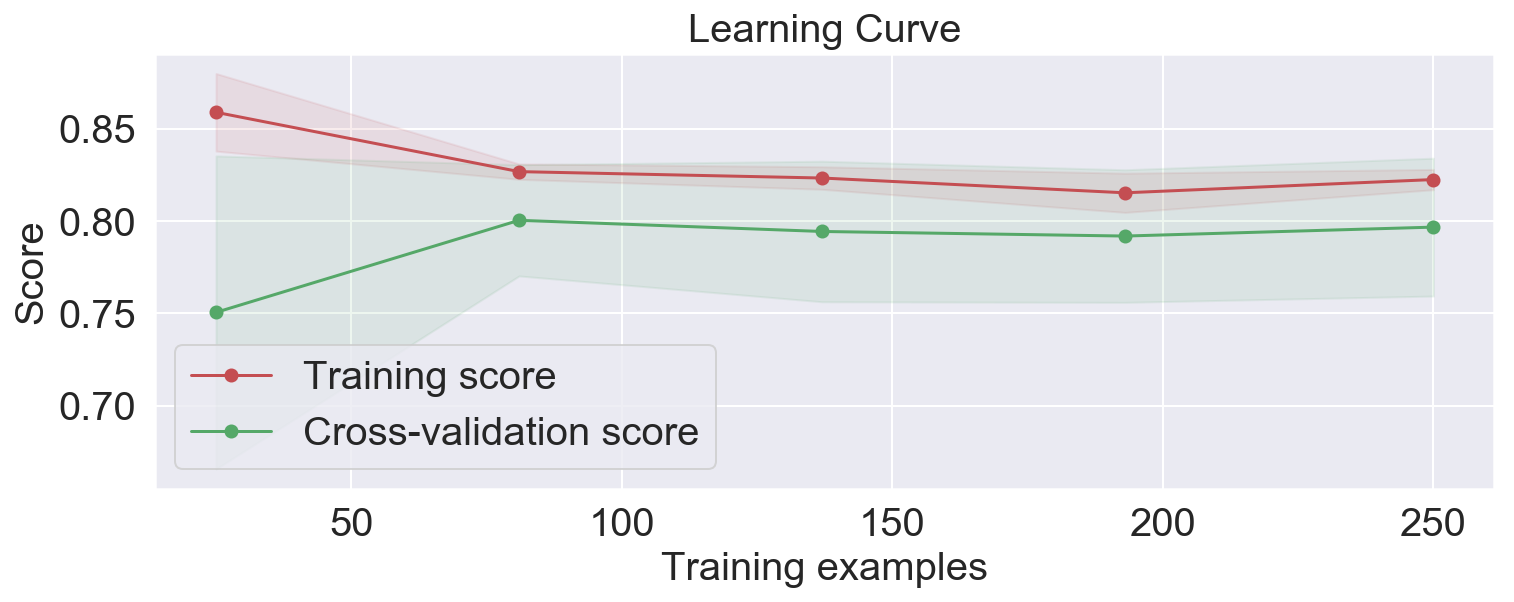

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=5, 
    scoring='r2', title_fontsize=20, text_fontsize=20, ax=ax)
ax.grid()

[0.81939243] 4.226967378016198


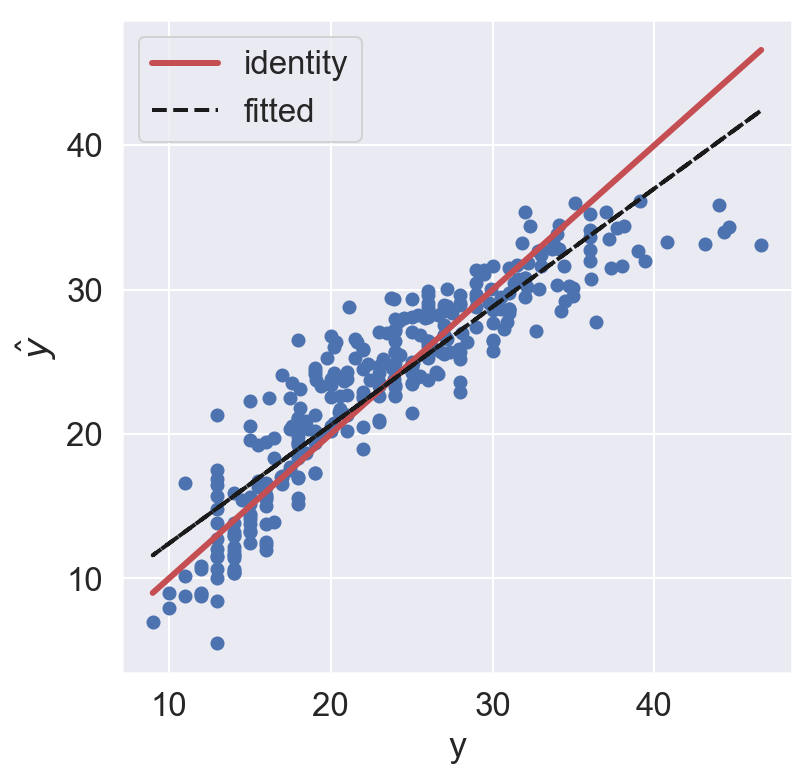

In [45]:
model_y = LinearRegression()
model_y.fit(y_train.values.reshape(-1, 1), predictions_train)
print(model_y.coef_, model_y.intercept_)

plt.figure(figsize=(6, 6))
plt.scatter(y_train, predictions_train)
plt.plot([y_train.min(), y_train.max()], [y_train.min(),y_train.max()], 
         lw=3, color='r', label='identity')
plt.plot(y_train, model_y.predict(y_train.values.reshape(-1, 1)),
         lw=2, linestyle='--', color='k', label='fitted')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')
plt.legend()
plt.show()

We can compare the residuals for the training and test sets.

In [46]:
residuals_train = y_train-predictions_train
residuals_test = y_test-predictions_test

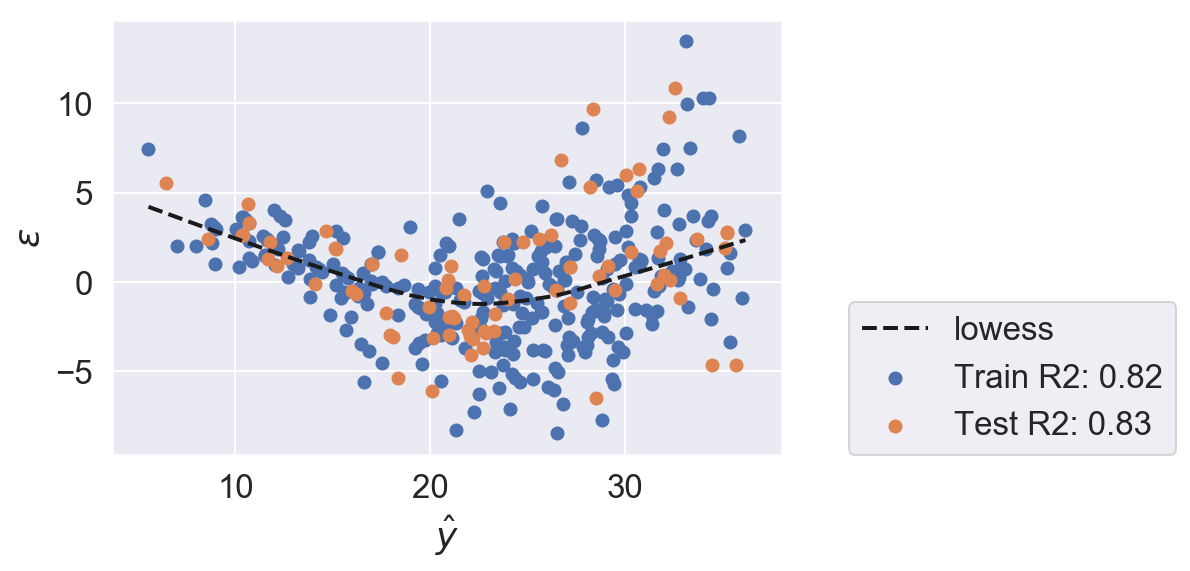

In [47]:
lowess_fit = sm.nonparametric.lowess(residuals_train,predictions_train)
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='k', ls='--', lw=2, label='lowess')
plt.scatter(predictions_train, residuals_train,
            label='Train R2: {:.2f}'.format(model.score(X_train, y_train)))
plt.scatter(predictions_test, residuals_test,
            label='Test R2: {:.2f}'.format(model.score(X_test, y_test)))
plt.xlabel('$\hat{y}$')
plt.ylabel('$\epsilon$')
plt.legend(loc=[1.1, 0])
plt.show()

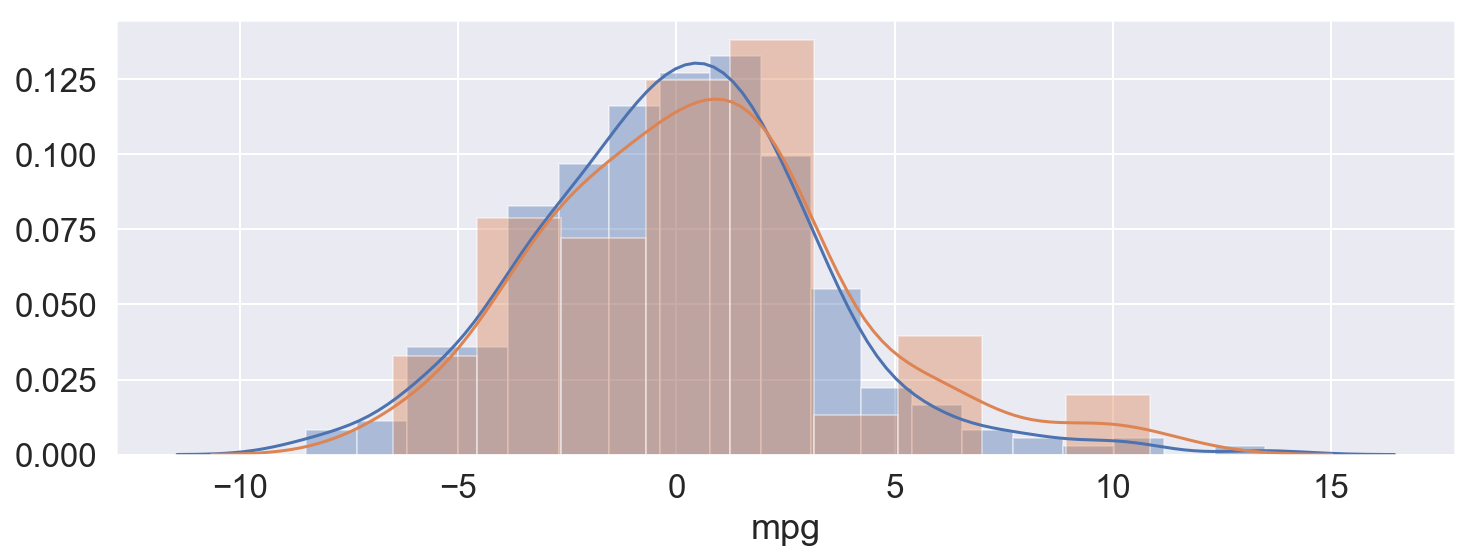

In [48]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.distplot(residuals_train, ax=ax)
sns.distplot(residuals_test, ax=ax)
plt.show()

## Explore the following options

- Experiment with the settings of the learning curve, e.g. train-sizes
- Use RidgeCV instead of LassoCV
- Add polynomial features before standardization and regularized regression